<a href="https://colab.research.google.com/github/enVives/TFG/blob/main/EvaluacioArquitectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import torch
import cv2
import random
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import wandb
import pylab as pl
import json

from glob import glob
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from torchvision import transforms,models
from torch import nn
from torch.utils.data import Dataset
from google.colab import files
from IPython.display import clear_output,display
from google.colab.patches import cv2_imshow
from PIL import Image
from skimage import io
from google.colab import drive


WEIGHTSANDBIASES = True
DOWNLOAD = False
CLAHE = False
# ORIGEN = '/content/drive/MyDrive/HAM10000/skin-cancer-mnist-ham10000/'



drive.mount('/content/drive')


if DOWNLOAD:
  !rm -rf /content/sample_data/*

  !kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

  !unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

#471be466c8949671a46c67e7aad0d5a0ac8c9dad

if WEIGHTSANDBIASES:
  wandb.login()

#torch.cuda.default_stream(torch.device('cuda'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


!rm -rf /content/sample_data/*

!kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

!unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

In [47]:

metadates = pd.read_csv('/content/sample_data/HAM10000_metadata.csv')
metadates = metadates.sort_values(by='image_id')
metadates.head()
print(metadates['dx'].value_counts())
print()
print(metadates['dx'].value_counts() / sum(metadates['dx'].value_counts()))

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

dx
nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: count, dtype: float64


nv: melanocytic nevi

vasc: vascular lesions

mel:melanoma

df: dermatofibroma

bkl: benign keratosis-like lesions

bcc: basal cell carcinoma

akiec: Actinic keratoses and intraepithelial carcinoma / Bowen's disease

In [48]:
class Formes(Dataset):
  #Classe on gestionarem les imatges dels fitxers
  dict_illnesses = {0 : 'nv', 1 : 'mel', 2 : 'bkl', 3 : 'bcc', 4 : 'akiec', 5 : 'vasc', 6 : 'df'}

  def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform
        #Per defecte pens que el color pot extreure característiques importants, per tant en primer lloc
        #entrenarem les imatges de color
        self.greyscale = False

  def __len__(self):
        return self.len

  def __addlabel__(self,label):
    self.labels = np.append(self.labels,label)

  def __addPath__(self,path):
    self.paths = np.append(self.paths,path)

  def __getdist__(self):
    return pd.Series(self.labels).value_counts()

  def __getlabels__(self):
    classes = [[],[],[],[],[],[],[]]
    for i in range(len(self.labels)):
      classes[self.labels[i]].append(i) #afegim l'index
    return classes

  def __redistribute__(self,percentages):
    #percentages: [15,15,10,10,5,5] percentatges que volem pujar de la resta de classes llevat de nv
    threshold = 0.005  #percentatge de marge que deixam a la redistribució
    Ntarget = self.len
    classes = self.__getlabels__() #indexos de cada clase
    afegir = np.array([0,0,0,0,0,0],dtype=np.int64) # de nv mai haurem d'afegir

    nmel = len(classes[1]) #nombre inicial de cada clase
    nbkl = len(classes[2])
    nbcc = len(classes[3])
    nakiec = len(classes[4])
    nvasc = len(classes[5])
    ndf = len(classes[6])

    while True:

      suma_actual = afegir.sum()

      operacio = percentages[0]*Ntarget - nmel
      afegir[0] +=  operacio if operacio > 0 else 0
      nmel += operacio if operacio > 0 else 0

      operacio = percentages[1]*Ntarget - nbkl
      afegir[1] += operacio if operacio > 0 else 0
      nbkl += operacio if operacio > 0 else 0

      operacio = percentages[2]*Ntarget - nbcc
      afegir[2] += operacio if operacio > 0 else 0
      nbcc += operacio if operacio > 0 else 0

      operacio = percentages[3]*Ntarget - nakiec
      afegir[3] += operacio if operacio > 0 else 0
      nakiec += operacio if operacio > 0 else 0

      operacio = percentages[4]*Ntarget - nvasc
      afegir[4] += operacio if operacio > 0 else 0
      nvasc += operacio if operacio > 0 else 0

      operacio = percentages[5]*Ntarget - ndf
      afegir[5] += operacio if operacio > 0 else 0
      ndf += operacio if operacio > 0 else 0

      if (afegir.sum()-suma_actual) < Ntarget*threshold:
        break

      Ntarget += (afegir.sum()-suma_actual)

    #Quedaria afegir a les imatges les còpies
    for i in range(len(afegir)):
      for j in range(afegir[i]):

          self.__addPath__(self.paths[classes[i+1][random.randint(0, len(classes[i+1]) - 1)]])
          self.__addlabel__(i+1)

    self.len = len(self.labels)

  def __setgreyscale__(self,mode):
    self.greyscale = mode

  def __getpath__(self,index):
    return self.paths[index]

  def __getitem__(self, index):
      path = self.paths[index]
      label = self.labels[index]

      image = cv2.imread(path, cv2.IMREAD_GRAYSCALE if self.greyscale else cv2.IMREAD_COLOR)

      #preprocessament
      if CLAHE:
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8,8))
        l_clahe = clahe.apply(l)
        lab_clahe = cv2.merge((l_clahe, a, b))
        image = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)


      if self.greyscale:
        image = Image.fromarray(image, mode="L")
      else:
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      image = self.transform(image)

      return image, label

In [49]:
def calcula_mitjana_desviacio(img_files_path):
  mitjana = np.array([0.0, 0.0, 0.0], dtype=np.float64)
  desviacio = np.array([0.0, 0.0, 0.0], dtype=np.float64)

  x,y = 256,256
  pixels_totals_canal = len(img_files_path) * x * y

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)

    mitjana += np.array([canal_r.sum(), canal_g.sum(), canal_b.sum()])
    #desviacio += np.array([(canal_r**2).sum(), (canal_g**2).sum(), (canal_b**2).sum()])

  mitjana = mitjana / pixels_totals_canal

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)
    desviacio += np.array([((canal_r-mitjana[0])**2).sum(), ((canal_g-mitjana[1])**2).sum(), ((canal_b-mitjana[2])**2).sum()])


  desviacio = np.sqrt(desviacio / pixels_totals_canal)

  return mitjana,desviacio

In [50]:
def load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

  illnes_dictionary = {
      'nv': 'Melanocytic nevi',
      'mel': 'Melanoma',
      'bkl': 'Benign keratosis-like lesions ',
      'bcc': 'Basal cell carcinoma',
      'akiec': 'Actinic keratoses and intraepithelial carcinoma / Bowens disease',
      'vasc': 'Vascular lesions',
      'df': 'Dermatofibroma'
  }

  img_files_1 = sorted(glob('/content/sample_data/HAM10000_images_part_1/*'))
  img_files_2 = sorted(glob('/content/sample_data/HAM10000_images_part_2/*'))
  img_files = img_files_1 + img_files_2

  img_files = np.array(img_files)


  imgid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in img_files}

  metadates['path'] = metadates['image_id'].map(imgid_path_dict.get)
  metadates['illness'] = metadates['dx'].map(illnes_dictionary.get)
  metadates['illness_code'] = metadates['dx'].map({'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6})

  #Aquest illness_code s'utilitzarà com a label de la enfermetat

  img_number = len(img_files)

  X = metadates.drop('illness_code',axis= 1)
  y = metadates['illness_code']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testing_dist, random_state=42, stratify=y)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valitation_dist/(training_dist+valitation_dist), random_state=42, stratify=y_train)

  #Una bona idea seria aplicar data augmentation al conjunt d'entrenament ja que les classes estan molt desbalancejades
  #Una altra bona idea seria emplear una funció de pèrdua que tengui en compte les classes desbalancejades.

  #Antes de guardar els datasets en classes Formes, hauriem de caluclar la mitjana i desviació típica de les imatges
  train_data = Formes(X_train['path'].to_numpy(),y_train.to_numpy(),transformation_training)
  test_data = Formes(X_test['path'].to_numpy(),y_test.to_numpy(),transformation_default)
  validation_data = Formes(X_val['path'].to_numpy(),y_val.to_numpy(),transformation_default)


  #prova1: [0.12,0.12,0.06,0.04,0.02,0.02]
  #prova2: [0.12,0.12,0.06,0.04,0.02,0.015]
  #prova3: [0.13,0.13,0.07,0.05,0.02,0.015]

  if distribution != None:
    train_data.__redistribute__(distribution)

  return train_data, validation_data,test_data


In [51]:
def get_weights():

  #diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}

  valors = metadates['dx'].value_counts()
  illnesses = valors.keys()
  weights = np.zeros(len(illnesses))

  i = 0
  for x in illnesses:
    y = valors[x]
    weights[i] = valors.sum() / y
    i+= 1

  weights = weights / weights.sum()

  return (1 - (weights[1]+weights[3]+weights[4])) / (weights[1]+weights[3]+weights[4]) ,weights

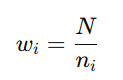

In [52]:
#veure_imatges(train_data,std,mean)

Ara ja tenim el training preparat. El provarem amb el validation a continuació

##ENTRENAMENT

In [53]:
def tria_model(numero_model,weights):
  if numero_model == 0:
    alexnetbinary = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

    alexnetbinary.classifier = nn.Sequential(
    torch.nn.Linear(9216, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 512),
    nn.ReLU(),
    torch.nn.Linear(512, 1)
    )
    pos_weight = torch.tensor(weights,device = device)
    # print(pos_weight.shape)
    # print(pos_weight)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return alexnetbinary,loss_fn

  # elif numero_model == 1:
  #   resnetbinary = models.resnet50(weights="IMAGENET1K_V1")
  #   resnetbinary.fc = nn.Linear(in_features=2048, out_features=1)

  #   pos_weight = torch.tensor(weights,device = device)
  #   loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

  #   return resnetbinary,loss_fn

  elif numero_model == 1:
    resnetbinary = models.resnet152(weights="IMAGENET1K_V1")
    num_features = resnetbinary.fc.in_features
    resnetbinary.fc = nn.Linear(in_features=num_features, out_features=1)

    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return resnetbinary,loss_fn

  elif numero_model == 2:
    googlenet = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1, aux_logits=True)
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    googlenet.aux_logits = False

    num_features = googlenet.fc.in_features
    googlenet.fc = nn.Linear(in_features=num_features, out_features=1)

    return googlenet,loss_fn

  elif numero_model == 3:
    efficientnet = models.efficientnet_b1(weights='IMAGENET1K_V1')
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    num_features = efficientnet.classifier[1].in_features
    efficientnet.classifier[1] = nn.Linear(in_features=num_features, out_features=1)

    return efficientnet,loss_fn

  elif numero_model == 4:

    alexnetmulticlass = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
    alexnetmulticlass.classifier[6] = nn.Linear(in_features=4096, out_features=7)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    return alexnetmulticlass,loss_fn

  # elif numero_model == 6:

  #   resnetmulticlass = models.resnet50(weights="IMAGENET1K_V1")
  #   num_features = resnetmulticlass.fc.in_features
  #   resnetmulticlass.fc = nn.Linear(in_features=num_features, out_features=7)

  #   weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
  #   loss_fn = nn.CrossEntropyLoss(weight=weights)

  #   return resnetmulticlass,loss_fn

  elif numero_model == 5:
    resnetmulticlass152 = models.resnet152(weights="IMAGENET1K_V1")
    num_features = resnetmulticlass152.fc.in_features
    resnetmulticlass152.fc = nn.Linear(in_features=num_features, out_features=7)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    return resnetmulticlass152,loss_fn

  elif numero_model == 6:

    googlenetmulticlass = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    num_features = googlenetmulticlass.fc.in_features
    googlenetmulticlass.fc = nn.Linear(in_features=num_features, out_features=1)

    return googlenetmulticlass,loss_fn

  elif numero_model == 7:

    efficientnetmulticlass = models.efficientnet_b1(weights='IMAGENET1K_V1')

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    num_features = efficientnetmulticlass.classifier[1].in_features
    efficientnetmulticlass.classifier[1] = nn.Linear(in_features=num_features, out_features=7)

    return efficientnetmulticlass,loss_fn



In [54]:
def converteix_a_binari(target):
  #{'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6}
  diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}
  target = ([[str(num.item())] for num in target])

  mapped_tensor = torch.tensor([[diseases[num[0]]] for num in target])
  return mapped_tensor

In [55]:
def train(model,loss_fn,dataloader,optimizer,epoch,device):

  train_acc = 0
  train_f1 = 0
  train_recall = 0
  train_precision = 0
  train_loss = 0

  for batch_num, (input_img, target) in tqdm(enumerate(dataloader), desc=f"Batches (Època {epoch})"):
        model.train()
        optimizer.zero_grad()

        input_img = input_img.to(device)
        output = model(input_img.to(device))

        #print(output.shape[1])

        if output.shape[1] > 1: #multiclass
          a = 1
        else: #binary
          target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
          target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

        if output.shape[1] > 1:
          target = target.to(device)
          loss = loss_fn(output, target)
        else:
          target = target.to(device)
          loss = loss_fn(output, target.float())


        if output.shape[1] > 1:
          output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits
          output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
          output = output.cpu().detach().numpy()
        else:
          output = torch.sigmoid(output)   #funció sigmoide per al cas binari
          output = (output.cpu().detach().numpy() > 0.5).astype(int)

        target = target.cpu().detach().numpy()

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            optimizer.step()

        #print(f"Pèrdua entrenament batch: {batch_num} epoch: {epoch+1}  train_loss: {loss.item()}")
        train_acc += accuracy_score(target,output)
        train_f1 += f1_score(target,output,average='weighted',zero_division=1)
        train_recall += recall_score(target,output,average='weighted',zero_division=1)
        train_precision += precision_score(target,output,average='weighted',zero_division=1)
        train_loss += loss.item()

  return train_acc,train_f1,train_recall,train_precision,train_loss


In [56]:
def validate(model,loss_fn,data_loader,device):
  val_acc = 0
  val_f1 = 0
  val_recall = 0
  val_precision = 0
  val_loss = 0

  model.eval()
  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(data_loader):

            input_img = input_img.to(device)
            output = model(input_img)


            if output.shape[1] > 1: #multiclass
              a = 1
            else: #binary
              target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
              target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

            if output.shape[1] > 1:
              target = target.to(device)
              loss = loss_fn(output, target)
            else:
              target = target.to(device)
              loss = loss_fn(output, target.float())


            if output.shape[1] > 1:
              output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits
              output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
              output = output.cpu().detach().numpy()
            else:
              output = torch.sigmoid(output)   #funció sigmoide per al cas binari
              output = (output.cpu().detach().numpy() > 0.5).astype(int)


            target = target.cpu().detach().numpy()

            val_acc  += accuracy_score(target,output)
            val_f1 += f1_score(target,output,average='weighted',zero_division=1)
            val_recall += recall_score(target,output,average='weighted',zero_division=1)
            val_precision += precision_score(target,output,average='weighted',zero_division=1)

            val_loss += loss.item()

  return val_acc,val_f1,val_recall,val_precision,val_loss

In [57]:
from ast import And
def execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,epochs,device):

  t_loss = np.zeros(epochs)
  v_loss = np.zeros(epochs)
  acc_t = np.zeros(epochs)
  acc_v = np.zeros(epochs)
  f1_t = np.zeros(epochs)
  f1_v = np.zeros(epochs)
  recall_t = np.zeros(epochs)
  recall_v = np.zeros(epochs)


  interval = 5
  requerit = 0.017
  last_loss = float('inf')

  epoch_number = 0

  pbar = tqdm(range(1, epochs + 1))  # tdqm permet tenir text dinàmic

  for epoch in pbar:

      train_loss = 0
      train_acc = 0
      train_precision = 0
      train_f1 = 0
      train_recall = 0
      val_acc = 0
      val_recall = 0
      val_f1 = 0
      val_loss = 0
      val_precision = 0

      batch_num = 1

      train_acc,train_f1,train_recall,train_precision,train_loss = train(model,loss_fn,train_loader,optimizer,epoch,device)
      val_acc,val_f1,val_recall,val_precision,val_loss  = validate(model,loss_fn,val_loader,device)

      if WEIGHTSANDBIASES:

        training_metrics = {"train/train_loss": train_loss/len(train_loader),
                        "train/train_acc":train_acc/len(train_loader),
                        "train/train_f1":train_f1/len(train_loader),
                        "train/train_recall":train_recall/len(train_loader),
                        "train/train_precision":train_precision/len(train_loader)}

        val_metrics = {"val/val_loss": val_loss/len(val_loader),
                      "val/val_acc":val_acc/len(val_loader),
                      "val/val_f1":val_f1/len(val_loader),
                      "val/val_recall": val_recall/len(val_loader),
                      "val/val_precision": val_precision/len(val_loader)}

        wandb.log({**training_metrics, **val_metrics})

      # RESULTATS
      train_loss /= len(train_loader)
      train_acc /= len(train_loader)
      train_f1 /= len(train_loader)
      train_recall /= len(train_loader)
      train_precision /= len(train_loader)

      print(f"Pèrdua entrenament epoch: {epoch}  train_loss: {train_loss}")
      print(f"Accuracy train epoch: {epoch}  train_acc: {train_acc}")
      print(f"F1 train epoch: {epoch}  train_f1: {train_f1}")
      print(f"Recall train epoch: {epoch}  train_recall: {train_recall}")

      val_loss /= len(val_loader)
      val_acc /= len(val_loader)
      val_f1 /= len(val_loader)
      val_recall /= len(val_loader)
      val_precision /= len(val_loader)

      print()
      print()
      print(f"Pèrdua validació epoch: {epoch}  val_loss: {val_loss}")
      print(f"Accuracy val epoch: {epoch}  val_acc: {val_acc}")
      print(f"F1 val epoch: {epoch}  val_f1: {val_f1}")
      print(f"Recall val epoch: {epoch}  val_recall: {val_recall}")
      print(f"Recall val epoch: {epoch}  val_precision: {val_precision}")



      if interval > 0:
        interval -= 1

      if interval == 0:
        if last_loss - requerit < train_loss:
            print("Early Stopping, no hem reduït ni un 0.03 de loss respecte 10 èpoques!!")
            break
        else:
          interval = 5
          last_loss = train_loss

  return model

In [58]:
def test(model,dataloader,weights_dir,loss_fn,device):

  model.load_state_dict(torch.load(weights_dir))

  test_acc = 0
  test_f1 = 0
  test_recall = 0
  test_precision = 0
  test_loss = 0

  json_obj = []

  model.eval()

  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(dataloader):

            input_img = input_img.to(device)
            output = model(input_img)

            dades = {}

            if output.shape[1] > 1: #multiclass
              a = 1
            else: #binary
              target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
              target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

            if output.shape[1] > 1:
              target = target.to(device)
              loss = loss_fn(output, target)
            else:
              target = target.to(device)
              loss = loss_fn(output, target.float())


            if output.shape[1] > 1:
              output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits

              dades["output"] = output.cpu().detach().tolist() #guardam les probabilitats de l'output

              output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
              output = output.cpu().detach().numpy()
            else:
              output = torch.sigmoid(output)   #funció sigmoide per al cas binari

              dades["output"] = output.cpu().detach().tolist() #guardam les probabilitats de l'output

              output = (output.cpu().detach().numpy() > 0.5).astype(int)

            dades["target"] = target.cpu().detach().tolist()

            target = target.cpu().detach().numpy()

            dades["top1-accuracy"] = accuracy_score(target,output)
            test_acc  += dades["top1-accuracy"]
            dades["f1-score"] = f1_score(target,output,average='weighted',zero_division=1)
            test_f1 += dades["f1-score"]
            dades["recall"] = recall_score(target,output,average='weighted',zero_division=1)
            test_recall += dades["recall"]
            dades["precision"] = precision_score(target,output,average='weighted',zero_division=1)
            test_precision += dades["precision"]

            dades["loss"] = loss.item()
            test_loss += dades["loss"]

            json_obj.append(dades)


  return json_obj

In [59]:
def veure_imatges(train_data):
  for i in range(len(train_data)):
    path = train_data.__getpath__(i)
    clean_img = cv2.imread(path)
    mean, std = cv2.meanStdDev(clean_img)
    clean_img = torch.tensor(clean_img)

    imatge,label = train_data.__getitem__(i)

    std = std.flatten()
    mean = mean.flatten()
    imatge = imatge * (std[:, None, None]) + (mean[:, None, None])

    img_numpy = imatge.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    clean_img = clean_img.permute(1, 2, 0).numpy() #clean_img no es un torch

    combined_image = np.concatenate((img_numpy, clean_img), axis=1)
    cv2_imshow(combined_image)

    time.sleep(5)
    clear_output(wait=True)

In [60]:
from itertools import product
BINARY = True #Si volem que el resultat de la classificació sigui 0 i 1

architectures = {'alexnet': 0,'resnet152':1,'inceptionv3':2,'efficientnetb1':3,'alexnetmulticlass':4,'resnet152multiclass':5,'inceptionv3multiclass':6,'efficientnetb1multiclass':7}
nom_model = 'efficientnetb1multiclass'
MODEL = architectures[nom_model]

TRAINING = 0.80
VALIDATION = 0.10
TESTING = 0.10
SIZE = 224


mean = torch.tensor([194.57463374, 139.13953272, 145.36132088]) /255 #rgb
std = torch.tensor([35.92275236, 38.90347617, 43.33101831]) / 255

TRANSFORMATIONS = []
DISTRIBUTIONS = None


transform = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std)
])

transform_training = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=20),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.1)),
    # transforms.RandomGrayscale(p = 0.4),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std),
])

CLAHE = True
train_data,validation_data,test_data = load_sets(transform_training,transform,TRAINING,VALIDATION,TESTING,DISTRIBUTIONS)


EPOCHS = 60
batch_size = 32

binary_weights, multiple_weights = get_weights()

if MODEL < 4:
  weights = binary_weights
else:
  weights = multiple_weights

print(weights)
learning_rate  = 1e-5


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

model,loss_fn = tria_model(MODEL,weights)


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.to(device)

projectes = ['Ham10000-AlexnetBinary','Ham1000-Resnet152Binary','Ham10000-Inceptionv3Binary','Ham10000-EfficientNetB1Binary',
              'Ham10000-AlexnetMulticlass','Ham10000Resnet152Multiclass','Ham10000-Inceptionv3Multiclass','Ham10000-EfficientNetB1Multiclass']

parametres_training = {
                "epochs": EPOCHS,
                "batch_size": batch_size,
                "lr": learning_rate,
                "trsize":len(train_loader),
                "trdist":TRAINING,
                "vsize":len(val_loader),
                "vdist":VALIDATION,
                "testsize":len(test_loader),
                "testdist": TESTING,
                "loss_weights":str(weights),
                "CLAHE": CLAHE,
                "data_augmentation": str(transform_training)
}

carpeta_drive = '/content/drive/MyDrive/Runs/' + projectes[MODEL]
os.makedirs(carpeta_drive, exist_ok=True) #cream la carpeta si no existeix

current_runs = len([d for d in os.listdir(carpeta_drive) if os.path.isdir(os.path.join(carpeta_drive, d))]) #número d'execucions fetes de cada model

#cada execució tindrà la seva carpeta numerada

json_object = json.dumps(parametres_training,indent = 2)

#cream la carpeta de l'execució

num_execucio = str(current_runs)
carpeta_execucio = carpeta_drive+"/"+ num_execucio
os.makedirs(carpeta_execucio,exist_ok=True)

#afegim la informació d'entrenament a la carpeta
with open(carpeta_execucio+"/training_info.json", "w") as outfile:
  outfile.write(json_object)


if WEIGHTSANDBIASES:
    wandb.init(
            project=projectes[MODEL],
            config={
                "epochs": EPOCHS,
                "batch_size": batch_size,
                "lr": learning_rate,
                "trsize":len(train_loader),
                "trdist":TRAINING,
                "vsize":len(val_loader),
                "vdist":VALIDATION,
                "weights":weights,
                "CLAHE": CLAHE,
                })
    config = wandb.config
    print(config)

#guardam els pesos a la carpeta de drive
best_model = execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,EPOCHS,device)
carpeta_pesos = carpeta_execucio+'/pesos_'+nom_model+'_'+num_execucio+'.pt'
torch.save(model.state_dict(), carpeta_pesos )

#també guardam els resultats del test a la carpeta de drive
carpeta_pesos = carpeta_execucio+'/pesos_'+nom_model+'_'+str(current_runs)+'.pt'

resultats = test(model,test_loader,carpeta_pesos,loss_fn,device)

with open(carpeta_execucio+"/testing_info.json", "w") as outfile:
    json.dump(resultats, outfile, indent=3)


wandb.finish()

[0.00657042 0.03958192 0.04008614 0.08570948 0.13472377 0.31024417
 0.3830841 ]


{'epochs': 60, 'batch_size': 32, 'lr': 1e-05, 'trsize': 251, 'trdist': 0.8, 'vsize': 32, 'vdist': 0.1, 'weights': [0.0065704208816761995, 0.03958191555403316, 0.04008614377765142, 0.08570947862186559, 0.13472376761969088, 0.31024416909604874, 0.383084104449034], 'CLAHE': True}


  0%|          | 0/60 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 1.8923697333886804
Accuracy train epoch: 1  train_acc: 0.27810349511046717
F1 train epoch: 1  train_f1: 0.3464968041434999
Recall train epoch: 1  train_recall: 0.27810349511046717


Pèrdua validació epoch: 1  val_loss: 1.8211786076426506
Accuracy val epoch: 1  val_acc: 0.414453125
F1 val epoch: 1  val_f1: 0.4855465585909284
Recall val epoch: 1  val_recall: 0.414453125
Recall val epoch: 1  val_precision: 0.6749841314093381


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 1.7558802285517354
Accuracy train epoch: 2  train_acc: 0.42982614994567186
F1 train epoch: 2  train_f1: 0.5006298527406359
Recall train epoch: 2  train_recall: 0.42982614994567186


Pèrdua validació epoch: 2  val_loss: 1.6971441358327866
Accuracy val epoch: 2  val_acc: 0.56484375
F1 val epoch: 2  val_f1: 0.6169597780959992
Recall val epoch: 2  val_recall: 0.56484375
Recall val epoch: 2  val_precision: 0.7607726562169769


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 1.6020615295584932
Accuracy train epoch: 3  train_acc: 0.5365130387540746
F1 train epoch: 3  train_f1: 0.5992874836725247
Recall train epoch: 3  train_recall: 0.5365130387540746


Pèrdua validació epoch: 3  val_loss: 1.534916926175356
Accuracy val epoch: 3  val_acc: 0.60078125
F1 val epoch: 3  val_f1: 0.6442307309720228
Recall val epoch: 3  val_recall: 0.60078125
Recall val epoch: 3  val_precision: 0.7739394856997699


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 1.437247039787323
Accuracy train epoch: 4  train_acc: 0.5910335929011228
F1 train epoch: 4  train_f1: 0.6499225271319244
Recall train epoch: 4  train_recall: 0.5910335929011228


Pèrdua validació epoch: 4  val_loss: 1.4023156482726336
Accuracy val epoch: 4  val_acc: 0.60859375
F1 val epoch: 4  val_f1: 0.6599628238515164
Recall val epoch: 4  val_recall: 0.60859375
Recall val epoch: 4  val_precision: 0.7865574984751514


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 1.307417778854826
Accuracy train epoch: 5  train_acc: 0.61321758420862
F1 train epoch: 5  train_f1: 0.667173207993386
Recall train epoch: 5  train_recall: 0.61321758420862


Pèrdua validació epoch: 5  val_loss: 1.2520022355020046
Accuracy val epoch: 5  val_acc: 0.6341796875
F1 val epoch: 5  val_f1: 0.6850756774392004
Recall val epoch: 5  val_recall: 0.6341796875
Recall val epoch: 5  val_precision: 0.7943698928494939


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 1.1886468952395526
Accuracy train epoch: 6  train_acc: 0.6352657551611735
F1 train epoch: 6  train_f1: 0.6856943514268337
Recall train epoch: 6  train_recall: 0.6352657551611735


Pèrdua validació epoch: 6  val_loss: 1.1620521005243063
Accuracy val epoch: 6  val_acc: 0.6466796875
F1 val epoch: 6  val_f1: 0.6928306671007772
Recall val epoch: 6  val_recall: 0.6466796875
Recall val epoch: 6  val_precision: 0.8037758497248918


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 1.1088338914620448
Accuracy train epoch: 7  train_acc: 0.6521867077145961
F1 train epoch: 7  train_f1: 0.701797849786246
Recall train epoch: 7  train_recall: 0.6521867077145961


Pèrdua validació epoch: 7  val_loss: 1.0774051016196609
Accuracy val epoch: 7  val_acc: 0.6623046875
F1 val epoch: 7  val_f1: 0.7074300316837973
Recall val epoch: 7  val_recall: 0.6623046875
Recall val epoch: 7  val_precision: 0.8159502582479239


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 1.0269054024817934
Accuracy train epoch: 8  train_acc: 0.664014396957624
F1 train epoch: 8  train_f1: 0.7104004502097139
Recall train epoch: 8  train_recall: 0.664014396957624


Pèrdua validació epoch: 8  val_loss: 1.0180013496428728
Accuracy val epoch: 8  val_acc: 0.687109375
F1 val epoch: 8  val_f1: 0.725413203530653
Recall val epoch: 8  val_recall: 0.687109375
Recall val epoch: 8  val_precision: 0.8125720706609861


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.9503533025661788
Accuracy train epoch: 9  train_acc: 0.6751063926113726
F1 train epoch: 9  train_f1: 0.7214116972423325
Recall train epoch: 9  train_recall: 0.6751063926113726


Pèrdua validació epoch: 9  val_loss: 0.9170017028227448
Accuracy val epoch: 9  val_acc: 0.6869140625
F1 val epoch: 9  val_f1: 0.726876749647207
Recall val epoch: 9  val_recall: 0.6869140625
Recall val epoch: 9  val_precision: 0.8315462679574694


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.9130095157965246
Accuracy train epoch: 10  train_acc: 0.6865605758783049
F1 train epoch: 10  train_f1: 0.7302694325514635
Recall train epoch: 10  train_recall: 0.6865605758783049


Pèrdua validació epoch: 10  val_loss: 0.9257536707445979
Accuracy val epoch: 10  val_acc: 0.7091796875
F1 val epoch: 10  val_f1: 0.7455418194374204
Recall val epoch: 10  val_recall: 0.7091796875
Recall val epoch: 10  val_precision: 0.8356889873522358


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.843698547418374
Accuracy train epoch: 11  train_acc: 0.6896618073161898
F1 train epoch: 11  train_f1: 0.7325782226432362
Recall train epoch: 11  train_recall: 0.6896618073161898


Pèrdua validació epoch: 11  val_loss: 0.833608235232532
Accuracy val epoch: 11  val_acc: 0.73203125
F1 val epoch: 11  val_f1: 0.7654157146980446
Recall val epoch: 11  val_recall: 0.73203125
Recall val epoch: 11  val_precision: 0.8494290884387923


Batches (Època 12): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 12  train_loss: 0.8179879431943019
Accuracy train epoch: 12  train_acc: 0.7033230713509598
F1 train epoch: 12  train_f1: 0.7427871548223766
Recall train epoch: 12  train_recall: 0.7033230713509598


Pèrdua validació epoch: 12  val_loss: 0.8081809058785439
Accuracy val epoch: 12  val_acc: 0.717578125
F1 val epoch: 12  val_f1: 0.7513948770237124
Recall val epoch: 12  val_recall: 0.717578125
Recall val epoch: 12  val_precision: 0.8403591763601677


Batches (Època 13): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 13  train_loss: 0.7437007934211259
Accuracy train epoch: 13  train_acc: 0.7171767475552335
F1 train epoch: 13  train_f1: 0.7558164455072058
Recall train epoch: 13  train_recall: 0.7171767475552335


Pèrdua validació epoch: 13  val_loss: 0.787833291105926
Accuracy val epoch: 13  val_acc: 0.719921875
F1 val epoch: 13  val_f1: 0.7516520582716198
Recall val epoch: 13  val_recall: 0.719921875
Recall val epoch: 13  val_precision: 0.8306196379023223


Batches (Època 14): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 14  train_loss: 0.7437232330263374
Accuracy train epoch: 14  train_acc: 0.7121966678739586
F1 train epoch: 14  train_f1: 0.7510134355753183
Recall train epoch: 14  train_recall: 0.7121966678739586


Pèrdua validació epoch: 14  val_loss: 0.7612781971693039
Accuracy val epoch: 14  val_acc: 0.7267578125
F1 val epoch: 14  val_f1: 0.7630318190529995
Recall val epoch: 14  val_recall: 0.7267578125
Recall val epoch: 14  val_precision: 0.8558188738130205


Batches (Època 15): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 15  train_loss: 0.7343057280636404
Accuracy train epoch: 15  train_acc: 0.7247600507062658
F1 train epoch: 15  train_f1: 0.7643504914144231
Recall train epoch: 15  train_recall: 0.7247600507062658


Pèrdua validació epoch: 15  val_loss: 0.7322883224114776
Accuracy val epoch: 15  val_acc: 0.71953125
F1 val epoch: 15  val_f1: 0.7503340767565374
Recall val epoch: 15  val_recall: 0.71953125
Recall val epoch: 15  val_precision: 0.8470668598427085


Batches (Època 16): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 16  train_loss: 0.6838619292850988
Accuracy train epoch: 16  train_acc: 0.7299664976457805
F1 train epoch: 16  train_f1: 0.7659351384941806
Recall train epoch: 16  train_recall: 0.7299664976457805


Pèrdua validació epoch: 16  val_loss: 0.6896870573982596
Accuracy val epoch: 16  val_acc: 0.7361328125
F1 val epoch: 16  val_f1: 0.7610185771264767
Recall val epoch: 16  val_recall: 0.7361328125
Recall val epoch: 16  val_precision: 0.8487053407756835


Batches (Època 17): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 17  train_loss: 0.6631074803046496
Accuracy train epoch: 17  train_acc: 0.7299891343716045
F1 train epoch: 17  train_f1: 0.7660285316148273
Recall train epoch: 17  train_recall: 0.7299891343716045


Pèrdua validació epoch: 17  val_loss: 0.700039551127702
Accuracy val epoch: 17  val_acc: 0.7337890625
F1 val epoch: 17  val_f1: 0.7655985123671589
Recall val epoch: 17  val_recall: 0.7337890625
Recall val epoch: 17  val_precision: 0.8496191703272084


Batches (Època 18): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 18  train_loss: 0.6251517147181993
Accuracy train epoch: 18  train_acc: 0.7458008873596522
F1 train epoch: 18  train_f1: 0.7792324393592704
Recall train epoch: 18  train_recall: 0.7458008873596522


Pèrdua validació epoch: 18  val_loss: 0.6784786693751812
Accuracy val epoch: 18  val_acc: 0.7498046875
F1 val epoch: 18  val_f1: 0.7785632676504911
Recall val epoch: 18  val_recall: 0.7498046875
Recall val epoch: 18  val_precision: 0.8570693911064867


Batches (Època 19): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 19  train_loss: 0.6382697028111651
Accuracy train epoch: 19  train_acc: 0.7434579862368706
F1 train epoch: 19  train_f1: 0.7790426332118531
Recall train epoch: 19  train_recall: 0.7434579862368706


Pèrdua validació epoch: 19  val_loss: 0.6701583042740822
Accuracy val epoch: 19  val_acc: 0.7546875
F1 val epoch: 19  val_f1: 0.7871400274173851
Recall val epoch: 19  val_recall: 0.7546875
Recall val epoch: 19  val_precision: 0.8679737832305845


Batches (Època 20): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 20  train_loss: 0.603300812413018
Accuracy train epoch: 20  train_acc: 0.7521504889532777
F1 train epoch: 20  train_f1: 0.7868074633242909
Recall train epoch: 20  train_recall: 0.7521504889532777


Pèrdua validació epoch: 20  val_loss: 0.658981604501605
Accuracy val epoch: 20  val_acc: 0.7455078125
F1 val epoch: 20  val_f1: 0.7743481164444427
Recall val epoch: 20  val_recall: 0.7455078125
Recall val epoch: 20  val_precision: 0.8397095294270519


Batches (Època 21): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 21  train_loss: 0.6011267167875967
Accuracy train epoch: 21  train_acc: 0.7525239949293734
F1 train epoch: 21  train_f1: 0.7866594163901742
Recall train epoch: 21  train_recall: 0.7525239949293734


Pèrdua validació epoch: 21  val_loss: 0.6402633697725832
Accuracy val epoch: 21  val_acc: 0.7662109375
F1 val epoch: 21  val_f1: 0.7956598030597671
Recall val epoch: 21  val_recall: 0.7662109375
Recall val epoch: 21  val_precision: 0.8646415677421536


Batches (Època 22): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 22  train_loss: 0.571830910752969
Accuracy train epoch: 22  train_acc: 0.7588622781600869
F1 train epoch: 22  train_f1: 0.7913590665604076
Recall train epoch: 22  train_recall: 0.7588622781600869


Pèrdua validació epoch: 22  val_loss: 0.6521669793874025
Accuracy val epoch: 22  val_acc: 0.7728515625
F1 val epoch: 22  val_f1: 0.7995278241172309
Recall val epoch: 22  val_recall: 0.7728515625
Recall val epoch: 22  val_precision: 0.8704747848180464


Batches (Època 23): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 23  train_loss: 0.5709653203468399
Accuracy train epoch: 23  train_acc: 0.7639781781963056
F1 train epoch: 23  train_f1: 0.79656623533433
Recall train epoch: 23  train_recall: 0.7639781781963056


Pèrdua validació epoch: 23  val_loss: 0.5833027120679617
Accuracy val epoch: 23  val_acc: 0.7705078125
F1 val epoch: 23  val_f1: 0.8012531259571034
Recall val epoch: 23  val_recall: 0.7705078125
Recall val epoch: 23  val_precision: 0.8694726348287022


Batches (Època 24): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 24  train_loss: 0.541169784161674
Accuracy train epoch: 24  train_acc: 0.7629595255342267
F1 train epoch: 24  train_f1: 0.7944344250813266
Recall train epoch: 24  train_recall: 0.7629595255342267


Pèrdua validació epoch: 24  val_loss: 0.5745087466202676
Accuracy val epoch: 24  val_acc: 0.768359375
F1 val epoch: 24  val_f1: 0.7980668611750334
Recall val epoch: 24  val_recall: 0.768359375
Recall val epoch: 24  val_precision: 0.8721398920843746


Batches (Època 25): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 25  train_loss: 0.511772449866709
Accuracy train epoch: 25  train_acc: 0.7730781419775443
F1 train epoch: 25  train_f1: 0.8034155940336702
Recall train epoch: 25  train_recall: 0.7730781419775443


Pèrdua validació epoch: 25  val_loss: 0.5533539829775691
Accuracy val epoch: 25  val_acc: 0.7658203125
F1 val epoch: 25  val_f1: 0.7945086139683001
Recall val epoch: 25  val_recall: 0.7658203125
Recall val epoch: 25  val_precision: 0.8683329955007072


Batches (Època 26): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 26  train_loss: 0.5113874784266331
Accuracy train epoch: 26  train_acc: 0.7730668236146323
F1 train epoch: 26  train_f1: 0.8041761592433417
Recall train epoch: 26  train_recall: 0.7730668236146323


Pèrdua validació epoch: 26  val_loss: 0.5778659493662417
Accuracy val epoch: 26  val_acc: 0.776171875
F1 val epoch: 26  val_f1: 0.7999388171452521
Recall val epoch: 26  val_recall: 0.776171875
Recall val epoch: 26  val_precision: 0.8689296967497857


Batches (Època 27): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 27  train_loss: 0.49151752194560383
Accuracy train epoch: 27  train_acc: 0.783140166606302
F1 train epoch: 27  train_f1: 0.8129727255360718
Recall train epoch: 27  train_recall: 0.783140166606302


Pèrdua validació epoch: 27  val_loss: 0.5524212066084146
Accuracy val epoch: 27  val_acc: 0.7697265625
F1 val epoch: 27  val_f1: 0.7988038668737805
Recall val epoch: 27  val_recall: 0.7697265625
Recall val epoch: 27  val_precision: 0.8593672455732625


Batches (Època 28): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 28  train_loss: 0.4759079809801512
Accuracy train epoch: 28  train_acc: 0.7841814559942051
F1 train epoch: 28  train_f1: 0.8124198622020603
Recall train epoch: 28  train_recall: 0.7841814559942051


Pèrdua validació epoch: 28  val_loss: 0.5530681288801134
Accuracy val epoch: 28  val_acc: 0.7751953125
F1 val epoch: 28  val_f1: 0.8010694060352986
Recall val epoch: 28  val_recall: 0.7751953125
Recall val epoch: 28  val_precision: 0.8651505579080173


Batches (Època 29): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 29  train_loss: 0.46639156935224496
Accuracy train epoch: 29  train_acc: 0.7855170228178197
F1 train epoch: 29  train_f1: 0.8145083318715887
Recall train epoch: 29  train_recall: 0.7855170228178197


Pèrdua validació epoch: 29  val_loss: 0.542344041634351
Accuracy val epoch: 29  val_acc: 0.7693359375
F1 val epoch: 29  val_f1: 0.7965556964310003
Recall val epoch: 29  val_recall: 0.7693359375
Recall val epoch: 29  val_precision: 0.8683828869130849


Batches (Època 30): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 30  train_loss: 0.4640170754901916
Accuracy train epoch: 30  train_acc: 0.7892634009416878
F1 train epoch: 30  train_f1: 0.8180361468143101
Recall train epoch: 30  train_recall: 0.7892634009416878


Pèrdua validació epoch: 30  val_loss: 0.5264235087670386
Accuracy val epoch: 30  val_acc: 0.7623046875
F1 val epoch: 30  val_f1: 0.7917415150667292
Recall val epoch: 30  val_recall: 0.7623046875
Recall val epoch: 30  val_precision: 0.8675212347331489


Batches (Època 31): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 31  train_loss: 0.44221653768503333
Accuracy train epoch: 31  train_acc: 0.7979559036580949
F1 train epoch: 31  train_f1: 0.8233076345544815
Recall train epoch: 31  train_recall: 0.7979559036580949


Pèrdua validació epoch: 31  val_loss: 0.5066334842704237
Accuracy val epoch: 31  val_acc: 0.7658203125
F1 val epoch: 31  val_f1: 0.7961599320304064
Recall val epoch: 31  val_recall: 0.7658203125
Recall val epoch: 31  val_precision: 0.8704135519562872


Batches (Època 32): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 32  train_loss: 0.43893628549647046
Accuracy train epoch: 32  train_acc: 0.7911196124592539
F1 train epoch: 32  train_f1: 0.8192059736855001
Recall train epoch: 32  train_recall: 0.7911196124592539


Pèrdua validació epoch: 32  val_loss: 0.5452575664967299
Accuracy val epoch: 32  val_acc: 0.776953125
F1 val epoch: 32  val_f1: 0.8028381235521204
Recall val epoch: 32  val_recall: 0.776953125
Recall val epoch: 32  val_precision: 0.8771907262939443


Batches (Època 33): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 33  train_loss: 0.4228842181869712
Accuracy train epoch: 33  train_acc: 0.8026756609923941
F1 train epoch: 33  train_f1: 0.827308186458261
Recall train epoch: 33  train_recall: 0.8026756609923941


Pèrdua validació epoch: 33  val_loss: 0.5076377945952117
Accuracy val epoch: 33  val_acc: 0.79375
F1 val epoch: 33  val_f1: 0.8150456562366049
Recall val epoch: 33  val_recall: 0.79375
Recall val epoch: 33  val_precision: 0.8718587425001898


Batches (Època 34): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 34  train_loss: 0.42130755659831
Accuracy train epoch: 34  train_acc: 0.8029246649764578
F1 train epoch: 34  train_f1: 0.8299931188841806
Recall train epoch: 34  train_recall: 0.8029246649764578


Pèrdua validació epoch: 34  val_loss: 0.4855256825685501
Accuracy val epoch: 34  val_acc: 0.778125
F1 val epoch: 34  val_f1: 0.8058155394506586
Recall val epoch: 34  val_recall: 0.778125
Recall val epoch: 34  val_precision: 0.8693230543328201


Batches (Època 35): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 35  train_loss: 0.40523490078183283
Accuracy train epoch: 35  train_acc: 0.8130319630568634
F1 train epoch: 35  train_f1: 0.8363953218519891
Recall train epoch: 35  train_recall: 0.8130319630568634


Pèrdua validació epoch: 35  val_loss: 0.49260648526251316
Accuracy val epoch: 35  val_acc: 0.7896484375
F1 val epoch: 35  val_f1: 0.8139327614559624
Recall val epoch: 35  val_recall: 0.7896484375
Recall val epoch: 35  val_precision: 0.8787716509676241


Batches (Època 36): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 36  train_loss: 0.38823770927599227
Accuracy train epoch: 36  train_acc: 0.8082782506338283
F1 train epoch: 36  train_f1: 0.8322057264153376
Recall train epoch: 36  train_recall: 0.8082782506338283


Pèrdua validació epoch: 36  val_loss: 0.5060693640261889
Accuracy val epoch: 36  val_acc: 0.80390625
F1 val epoch: 36  val_f1: 0.8242887752626361
Recall val epoch: 36  val_recall: 0.80390625
Recall val epoch: 36  val_precision: 0.8759464738516857


Batches (Època 37): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 37  train_loss: 0.38823527477651953
Accuracy train epoch: 37  train_acc: 0.8081537486417965
F1 train epoch: 37  train_f1: 0.8324988300625575
Recall train epoch: 37  train_recall: 0.8081537486417965


Pèrdua validació epoch: 37  val_loss: 0.4831014662049711
Accuracy val epoch: 37  val_acc: 0.786328125
F1 val epoch: 37  val_f1: 0.8130110932472485
Recall val epoch: 37  val_recall: 0.786328125
Recall val epoch: 37  val_precision: 0.8822901030973469


Batches (Època 38): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 38  train_loss: 0.39189838962369705
Accuracy train epoch: 38  train_acc: 0.8094214052879392
F1 train epoch: 38  train_f1: 0.836238577125891
Recall train epoch: 38  train_recall: 0.8094214052879392


Pèrdua validació epoch: 38  val_loss: 0.4791433559730649
Accuracy val epoch: 38  val_acc: 0.7962890625
F1 val epoch: 38  val_f1: 0.8177378181768769
Recall val epoch: 38  val_recall: 0.7962890625
Recall val epoch: 38  val_precision: 0.8859246578430439


Batches (Època 39): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 39  train_loss: 0.36657738044442406
Accuracy train epoch: 39  train_acc: 0.8148881745744295
F1 train epoch: 39  train_f1: 0.8384676185093054
Recall train epoch: 39  train_recall: 0.8148881745744295


Pèrdua validació epoch: 39  val_loss: 0.4905748488381505
Accuracy val epoch: 39  val_acc: 0.7904296875
F1 val epoch: 39  val_f1: 0.8177173520674677
Recall val epoch: 39  val_recall: 0.7904296875
Recall val epoch: 39  val_precision: 0.8796903465567223


Batches (Època 40): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 40  train_loss: 0.3667277979898263
Accuracy train epoch: 40  train_acc: 0.820343625498008
F1 train epoch: 40  train_f1: 0.843299054429554
Recall train epoch: 40  train_recall: 0.820343625498008


Pèrdua validació epoch: 40  val_loss: 0.451277625747025
Accuracy val epoch: 40  val_acc: 0.7978515625
F1 val epoch: 40  val_f1: 0.825986922064307
Recall val epoch: 40  val_recall: 0.7978515625
Recall val epoch: 40  val_precision: 0.8873916065426245


Batches (Època 41): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 41  train_loss: 0.3436452176763242
Accuracy train epoch: 41  train_acc: 0.8239881383556682
F1 train epoch: 41  train_f1: 0.8463469456126048
Recall train epoch: 41  train_recall: 0.8239881383556682


Pèrdua validació epoch: 41  val_loss: 0.5209903018549085
Accuracy val epoch: 41  val_acc: 0.7873046875
F1 val epoch: 41  val_f1: 0.8141226847669739
Recall val epoch: 41  val_recall: 0.7873046875
Recall val epoch: 41  val_precision: 0.8809422754979396


Batches (Època 42): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 42  train_loss: 0.36660434409560433
Accuracy train epoch: 42  train_acc: 0.8223582940963419
F1 train epoch: 42  train_f1: 0.8474049953046752
Recall train epoch: 42  train_recall: 0.8223582940963419


Pèrdua validació epoch: 42  val_loss: 0.45957239205017686
Accuracy val epoch: 42  val_acc: 0.8056640625
F1 val epoch: 42  val_f1: 0.8255176231985354
Recall val epoch: 42  val_recall: 0.8056640625
Recall val epoch: 42  val_precision: 0.8827003708090382


Batches (Època 43): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 43  train_loss: 0.3319116132667815
Accuracy train epoch: 43  train_acc: 0.8286852589641435
F1 train epoch: 43  train_f1: 0.8516214623185103
Recall train epoch: 43  train_recall: 0.8286852589641435


Pèrdua validació epoch: 43  val_loss: 0.4702344569377601
Accuracy val epoch: 43  val_acc: 0.7962890625
F1 val epoch: 43  val_f1: 0.8167847414048879
Recall val epoch: 43  val_recall: 0.7962890625
Recall val epoch: 43  val_precision: 0.8788468902053627


Batches (Època 44): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 44  train_loss: 0.3246709276955441
Accuracy train epoch: 44  train_acc: 0.8279608837377761
F1 train epoch: 44  train_f1: 0.8495969270833741
Recall train epoch: 44  train_recall: 0.8279608837377761


Pèrdua validació epoch: 44  val_loss: 0.46721080248244107
Accuracy val epoch: 44  val_acc: 0.8142578125
F1 val epoch: 44  val_f1: 0.8344845479955165
Recall val epoch: 44  val_recall: 0.8142578125
Recall val epoch: 44  val_precision: 0.885001354002713


Batches (Època 45): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 45  train_loss: 0.3326490144152565
Accuracy train epoch: 45  train_acc: 0.8308131111915973
F1 train epoch: 45  train_f1: 0.8532601939847984
Recall train epoch: 45  train_recall: 0.8308131111915973


Pèrdua validació epoch: 45  val_loss: 0.4771486781537533
Accuracy val epoch: 45  val_acc: 0.8173828125
F1 val epoch: 45  val_f1: 0.8349015512190324
Recall val epoch: 45  val_recall: 0.8173828125
Recall val epoch: 45  val_precision: 0.8831279908887149


Batches (Època 46): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 46  train_loss: 0.31702838514549325
Accuracy train epoch: 46  train_acc: 0.8295794096341905
F1 train epoch: 46  train_f1: 0.8499707647232404
Recall train epoch: 46  train_recall: 0.8295794096341905


Pèrdua validació epoch: 46  val_loss: 0.4824455473572016
Accuracy val epoch: 46  val_acc: 0.8099609375
F1 val epoch: 46  val_f1: 0.8333922390061194
Recall val epoch: 46  val_recall: 0.8099609375
Recall val epoch: 46  val_precision: 0.8892818283630898


Batches (Època 47): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 47  train_loss: 0.3150819290384828
Accuracy train epoch: 47  train_acc: 0.8384190510684535
F1 train epoch: 47  train_f1: 0.8587334191468482
Recall train epoch: 47  train_recall: 0.8384190510684535


Pèrdua validació epoch: 47  val_loss: 0.4627490963321179
Accuracy val epoch: 47  val_acc: 0.80546875
F1 val epoch: 47  val_f1: 0.8221414291792826
Recall val epoch: 47  val_recall: 0.80546875
Recall val epoch: 47  val_precision: 0.8784357651274177


Batches (Època 48): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 48  train_loss: 0.3121349777417829
Accuracy train epoch: 48  train_acc: 0.8345594893154654
F1 train epoch: 48  train_f1: 0.8557278960027515
Recall train epoch: 48  train_recall: 0.8345594893154654


Pèrdua validació epoch: 48  val_loss: 0.4748649992980063
Accuracy val epoch: 48  val_acc: 0.8140625
F1 val epoch: 48  val_f1: 0.8319528229402475
Recall val epoch: 48  val_recall: 0.8140625
Recall val epoch: 48  val_precision: 0.8844171051750296


Batches (Època 49): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 49  train_loss: 0.3032006446821281
Accuracy train epoch: 49  train_acc: 0.8345594893154654
F1 train epoch: 49  train_f1: 0.8571152053929684
Recall train epoch: 49  train_recall: 0.8345594893154654


Pèrdua validació epoch: 49  val_loss: 0.43929093098267913
Accuracy val epoch: 49  val_acc: 0.82421875
F1 val epoch: 49  val_f1: 0.8405507914455596
Recall val epoch: 49  val_recall: 0.82421875
Recall val epoch: 49  val_precision: 0.884766811393559


Batches (Època 50): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 50  train_loss: 0.30090191737707866
Accuracy train epoch: 50  train_acc: 0.843761318362912
F1 train epoch: 50  train_f1: 0.862760674767367
Recall train epoch: 50  train_recall: 0.843761318362912


Pèrdua validació epoch: 50  val_loss: 0.43484016647562385
Accuracy val epoch: 50  val_acc: 0.82109375
F1 val epoch: 50  val_f1: 0.8407284383338262
Recall val epoch: 50  val_recall: 0.82109375
Recall val epoch: 50  val_precision: 0.8902176430468021


Batches (Època 51): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 51  train_loss: 0.29077108332004203
Accuracy train epoch: 51  train_acc: 0.8443951466859834
F1 train epoch: 51  train_f1: 0.864150897009209
Recall train epoch: 51  train_recall: 0.8443951466859834


Pèrdua validació epoch: 51  val_loss: 0.4426419632509351
Accuracy val epoch: 51  val_acc: 0.81875
F1 val epoch: 51  val_f1: 0.8380509861767855
Recall val epoch: 51  val_recall: 0.81875
Recall val epoch: 51  val_precision: 0.8865551366579327


Batches (Època 52): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 52  train_loss: 0.3064548976689696
Accuracy train epoch: 52  train_acc: 0.8390641977544367
F1 train epoch: 52  train_f1: 0.8610047096157937
Recall train epoch: 52  train_recall: 0.8390641977544367


Pèrdua validació epoch: 52  val_loss: 0.45177904702723026
Accuracy val epoch: 52  val_acc: 0.8169921875
F1 val epoch: 52  val_f1: 0.8351110245678294
Recall val epoch: 52  val_recall: 0.8169921875
Recall val epoch: 52  val_precision: 0.8908953613187449


Batches (Època 53): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 53  train_loss: 0.27623012381423995
Accuracy train epoch: 53  train_acc: 0.844632832307135
F1 train epoch: 53  train_f1: 0.8644055465438488
Recall train epoch: 53  train_recall: 0.844632832307135


Pèrdua validació epoch: 53  val_loss: 0.45366203878074884
Accuracy val epoch: 53  val_acc: 0.8228515625
F1 val epoch: 53  val_f1: 0.8429722543176182
Recall val epoch: 53  val_recall: 0.8228515625
Recall val epoch: 53  val_precision: 0.8954322732799735


Batches (Època 54): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 54  train_loss: 0.2773623546934223
Accuracy train epoch: 54  train_acc: 0.8491149040202824
F1 train epoch: 54  train_f1: 0.868223526297024
Recall train epoch: 54  train_recall: 0.8491149040202824


Pèrdua validació epoch: 54  val_loss: 0.4191498993895948
Accuracy val epoch: 54  val_acc: 0.820703125
F1 val epoch: 54  val_f1: 0.8405297156842181
Recall val epoch: 54  val_recall: 0.820703125
Recall val epoch: 54  val_precision: 0.894502110163618


Batches (Època 55): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 55  train_loss: 0.25003289348219493
Accuracy train epoch: 55  train_acc: 0.8568340275262586
F1 train epoch: 55  train_f1: 0.8742171123825969
Recall train epoch: 55  train_recall: 0.8568340275262586


Pèrdua validació epoch: 55  val_loss: 0.4400561093352735
Accuracy val epoch: 55  val_acc: 0.8298828125
F1 val epoch: 55  val_f1: 0.8481768520390351
Recall val epoch: 55  val_recall: 0.8298828125
Recall val epoch: 55  val_precision: 0.8952922431308048


Batches (Època 56): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 56  train_loss: 0.2591796764042748
Accuracy train epoch: 56  train_acc: 0.8547288120246287
F1 train epoch: 56  train_f1: 0.8725682245849121
Recall train epoch: 56  train_recall: 0.8547288120246287


Pèrdua validació epoch: 56  val_loss: 0.42836688947863877
Accuracy val epoch: 56  val_acc: 0.82109375
F1 val epoch: 56  val_f1: 0.8397726887252244
Recall val epoch: 56  val_recall: 0.82109375
Recall val epoch: 56  val_precision: 0.8916458787159117


Batches (Època 57): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 57  train_loss: 0.2777964418449725
Accuracy train epoch: 57  train_acc: 0.8481528431727634
F1 train epoch: 57  train_f1: 0.8678387670911091
Recall train epoch: 57  train_recall: 0.8481528431727634


Pèrdua validació epoch: 57  val_loss: 0.4352127695456147
Accuracy val epoch: 57  val_acc: 0.8271484375
F1 val epoch: 57  val_f1: 0.8420770456916408
Recall val epoch: 57  val_recall: 0.8271484375
Recall val epoch: 57  val_precision: 0.8891029681377527


Batches (Època 58): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 58  train_loss: 0.23858148631346654
Accuracy train epoch: 58  train_acc: 0.8584751901484969
F1 train epoch: 58  train_f1: 0.8768956697308717
Recall train epoch: 58  train_recall: 0.8584751901484969


Pèrdua validació epoch: 58  val_loss: 0.4467285363934934
Accuracy val epoch: 58  val_acc: 0.8228515625
F1 val epoch: 58  val_f1: 0.8378432178032872
Recall val epoch: 58  val_recall: 0.8228515625
Recall val epoch: 58  val_precision: 0.884010604753647


Batches (Època 59): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 59  train_loss: 0.2456360106538254
Accuracy train epoch: 59  train_acc: 0.8596862549800797
F1 train epoch: 59  train_f1: 0.8777330795601246
Recall train epoch: 59  train_recall: 0.8596862549800797


Pèrdua validació epoch: 59  val_loss: 0.44085282797459513
Accuracy val epoch: 59  val_acc: 0.8181640625
F1 val epoch: 59  val_f1: 0.8366633009603078
Recall val epoch: 59  val_recall: 0.8181640625
Recall val epoch: 59  val_precision: 0.8914742925781702


Batches (Època 60): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 60  train_loss: 0.23528930204976128
Accuracy train epoch: 60  train_acc: 0.8644399674031148
F1 train epoch: 60  train_f1: 0.882227764525613
Recall train epoch: 60  train_recall: 0.8644399674031148


Pèrdua validació epoch: 60  val_loss: 0.40482366224750876
Accuracy val epoch: 60  val_acc: 0.8251953125
F1 val epoch: 60  val_f1: 0.8428815257012976
Recall val epoch: 60  val_recall: 0.8251953125
Recall val epoch: 60  val_precision: 0.8943125823411127
Early Stopping, no hem reduït ni un 0.03 de loss respecte 10 èpoques!!


<ipython-input-58-40d8a7b82253>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_dir))


train/train_acc,▁▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
train/train_f1,▁▃▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
train/train_loss,█▇▇▆▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train/train_precision,▁▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████
train/train_recall,▁▃▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val/val_acc,▁▄▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▇▇█▇██████████
val/val_f1,▁▄▄▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇██████████
val/val_loss,█▇▆▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/val_precision,▁▄▄▅▅▅▆▇▆▇▇▇▆▇▇▇▇▇▇▇▇▇████▇█████████████
val/val_recall,▁▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇█▇██████████
train/train_acc,0.86444
